# **Event 2 :  Tesla's Battery Day 2020**

#### Import Necessary Libraries :

In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the Data :

In [2]:
# Load the stock data
stock_data = pd.read_csv('/Users/kavu_rojasara/Downloads/TSLA_stock_data.csv')

In [3]:
# Load the twitter data
tweet_data = pd.read_csv('/Users/kavu_rojasara/Downloads/TSLA_twitter_data.csv')

In [4]:
# Ensure 'Date' columns are datetime format

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
tweet_data['Date'] = pd.to_datetime(tweet_data['Date'])

In [5]:
# Display first few rows of stock data
stock_data.head()

,Date,Open,Close,Adj Close,High,Low,Volume
0,2020-08-03,96.613335,99.000000,99.000000,100.653999,96.292000,132139500
1,2020-08-04,99.667336,99.133331,99.133331,101.827332,97.466667,126225000
2,2020-08-05,99.532669,99.001335,99.001335,99.989334,97.887337,74217000
3,2020-08-06,99.388664,99.305336,99.305336,101.153999,98.484001,89884500
4,2020-08-07,99.969330,96.847336,96.847336,99.983330,94.334000,133446000


In [6]:
# Display first few rows of twitter data
tweet_data.head()

,Date,Tweet
0,2020-08-03,Battery Day today. Following Tesla’s announcem...
1,2020-08-03,Battery Day has been all hype. Will Tesla actu...
2,2020-08-03,Tesla's Battery Day might be overhyped. Let's ...
3,2020-08-03,Tesla's Battery Day is creating a lot of buzz!
4,2020-08-03,Battery Day announcements have been a bit of a...


#### Sentiment Analysis with FinBERT :

In [7]:
# Initialize FinBERT sentiment pipeline
finbert = pipeline("sentiment-analysis", model = "yiyanghkust/finbert-tone", tokenizer = "yiyanghkust/finbert-tone")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [8]:
# Apply FinBERT to each tweet and get sentiment scores

def get_sentiment_score(text):
    result = finbert(text)[0]
    label = result['label']
    if label == "Positive":
        return 1  # Positive score
    elif label == "Neutral":
        return 0  # Neutral score
    elif label == "Negative":
        return -1  # Negative score

In [9]:
# Apply the function to the 'Tweet' column to populate 'Sentiment_Score'

tweet_data['Sentiment_Score'] = tweet_data['Tweet'].apply(get_sentiment_score)

In [10]:
tweet_data.head()

,Date,Tweet,Sentiment_Score
0,2020-08-03,Battery Day today. Following Tesla’s announcem...,0
1,2020-08-03,Battery Day has been all hype. Will Tesla actu...,0
2,2020-08-03,Tesla's Battery Day might be overhyped. Let's ...,0
3,2020-08-03,Tesla's Battery Day is creating a lot of buzz!,1
4,2020-08-03,Battery Day announcements have been a bit of a...,0


#### Aggregate Sentiment Scores by Date :

In [11]:
# Aggregating sentiment scores by date to get daily sentiment summary

daily_sentiment = tweet_data.groupby('Date').agg(
    Positive = ('Sentiment_Score', lambda x: (x == 1).sum()),
    Neutral = ('Sentiment_Score', lambda x: (x == 0).sum()),
    Negative = ('Sentiment_Score', lambda x: (x == -1).sum())
).reset_index()

In [12]:
# Print aggregated sentiment counts 
daily_sentiment.head()

,Date,Positive,Neutral,Negative
0,2020-08-03,14,56,8
1,2020-08-04,8,62,8
2,2020-08-05,12,56,10
3,2020-08-06,18,57,3
4,2020-08-07,18,57,3


#### Merge Sentiment with Stock Data :

In [13]:
# Merge stock data with daily sentiment data

data = pd.merge(stock_data, daily_sentiment, on = 'Date', how = 'left').fillna(0)  # Fill missing sentiment values with 0

In [14]:
data.head()

,Date,Open,Close,Adj Close,High,Low,Volume,Positive,Neutral,Negative
0,2020-08-03,96.613335,99.000000,99.000000,100.653999,96.292000,132139500,14,56,8
1,2020-08-04,99.667336,99.133331,99.133331,101.827332,97.466667,126225000,8,62,8
2,2020-08-05,99.532669,99.001335,99.001335,99.989334,97.887337,74217000,12,56,10
3,2020-08-06,99.388664,99.305336,99.305336,101.153999,98.484001,89884500,18,57,3
4,2020-08-07,99.969330,96.847336,96.847336,99.983330,94.334000,133446000,18,57,3


In [15]:
data.isnull().sum()

Date         0
Open         0
Close        0
Adj Close    0
High         0
Low          0
Volume       0
Positive     0
Neutral      0
Negative     0
dtype: int64

#### Exploratory Data Analysis :

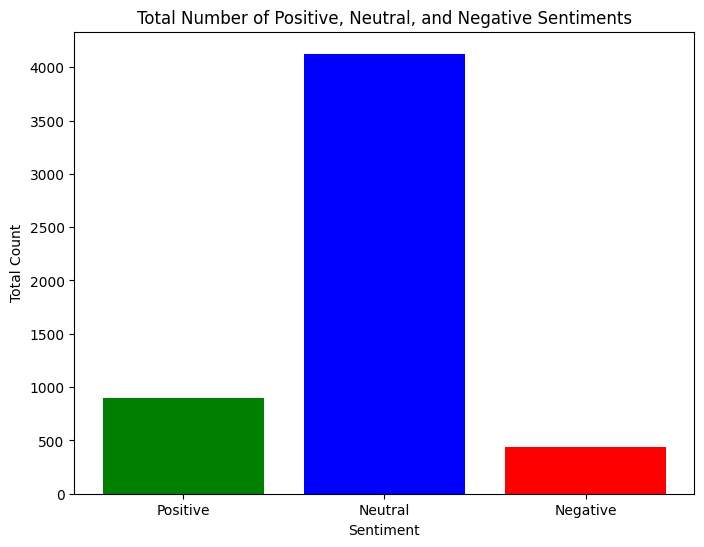

In [16]:
# Plot the counts of sentiments

# Calculate total counts for each sentiment
total_positive = data['Positive'].sum()
total_neutral = data['Neutral'].sum()
total_negative = data['Negative'].sum()

# Create a DataFrame for easier plotting
sentiment_totals = pd.DataFrame({
    'Sentiment': ['Positive', 'Neutral', 'Negative'],
    'Count': [total_positive, total_neutral, total_negative]
})

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_totals['Sentiment'], sentiment_totals['Count'], color=['green', 'blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Total Count')
plt.title('Total Number of Positive, Neutral, and Negative Sentiments')
plt.show()

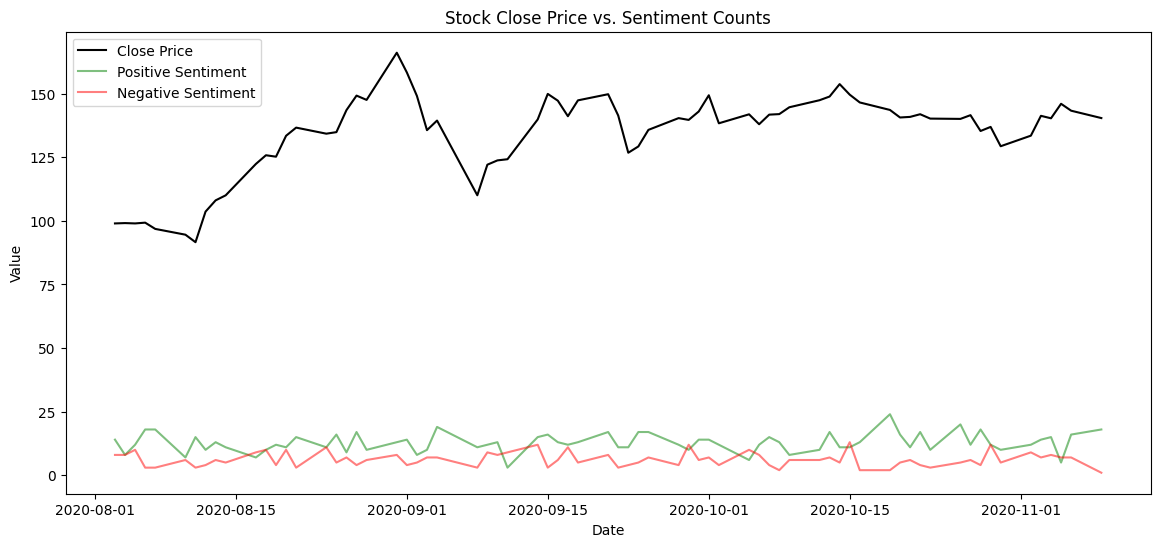

In [17]:
# Plot Close Price with Sentiment Counts

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='black')
plt.plot(data['Date'], data['Positive'], label='Positive Sentiment', color='green', alpha=0.5)
plt.plot(data['Date'], data['Negative'], label='Negative Sentiment', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Stock Close Price vs. Sentiment Counts')
plt.legend()
plt.show()

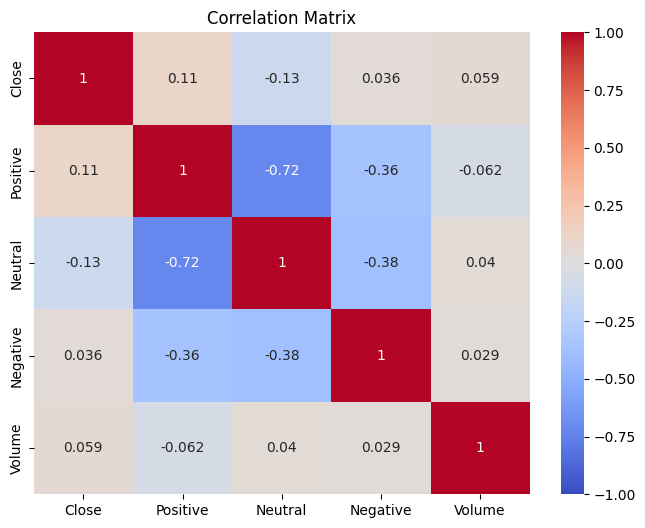

In [18]:
# Correlation matrix

correlation_matrix = data[['Close', 'Positive', 'Neutral', 'Negative', 'Volume']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#### Prepare Data for Linear Regression :

In [19]:
# Define features and target

features = ['Open', 'High', 'Low', 'Volume', 'Positive', 'Neutral', 'Negative']
target = 'Close'

In [20]:
# Create X and y
X = data[features]
y = data[target]

In [21]:
# Initialize cross-validation
tscv = TimeSeriesSplit(n_splits = 5)

#### Train the Linear Regression Model with Cross-Validation :

In [22]:
# Lists to store metrics
mse_scores = []
r2_scores = []

In [23]:
# Cross-validation loop
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

In [24]:
# Print mean metrics

print(f"Mean MSE across folds : {np.mean(mse_scores)}")
print(f"Mean R² across folds : {np.mean(r2_scores)}")

Mean MSE across folds : 7.425524036129491
Mean R² across folds : 0.8371049100138374


#### Plot the Results :

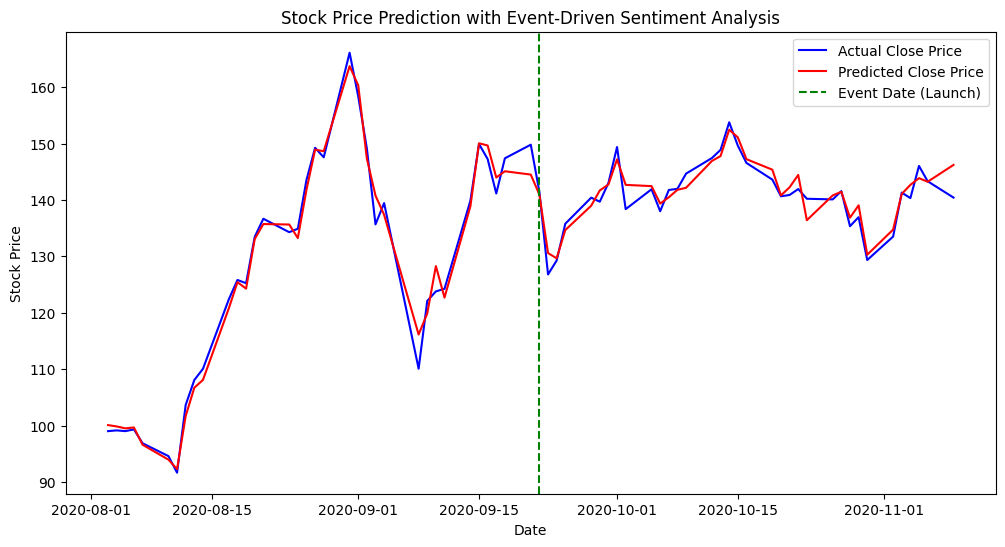

In [25]:
# Define event date
event_date = '2020-09-22'
event_date = pd.to_datetime(event_date)

# Plot actual vs. predicted close prices
plt.figure(figsize = (12, 6))
plt.plot(data['Date'], data['Close'], label = 'Actual Close Price', color = 'blue')
plt.plot(data['Date'], model.predict(X), label = 'Predicted Close Price', color = 'red')

# Add vertical line for event date
plt.axvline(event_date, color = 'green', linestyle = '--', linewidth = 1.5, label = 'Event Date (Launch)')

# Label the graph
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with Event-Driven Sentiment Analysis')
plt.legend()
plt.show()